In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.mmm.delayed_saturated_mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "mmm_roas"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
raw_df = pd.read_csv("../../../../data/mmm_roas_data.csv", parse_dates=["date"])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  131 non-null    datetime64[ns]
 1   dayofyear             131 non-null    int64         
 2   quarter               131 non-null    object        
 3   trend                 131 non-null    float64       
 4   cs                    131 non-null    float64       
 5   cc                    131 non-null    float64       
 6   seasonality           131 non-null    float64       
 7   z                     131 non-null    float64       
 8   x1                    131 non-null    float64       
 9   x2                    131 non-null    float64       
 10  epsilon               131 non-null    float64       
 11  x1_adstock            131 non-null    float64       
 12  x2_adstock            131 non-null    float64       
 13  x1_adstock_saturated

In [4]:
model_df = raw_df.copy().filter(["date", "x1", "x2", "y"])

In [5]:
mmm = MMM(
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    date_column="date",
    channel_columns=["x1", "x2"],
    time_varying_intercept=True,
    time_varying_media=True,
    yearly_seasonality=5,
)

y = model_df["y"]
X = model_df.drop(columns=["y"])

mmm.fit(X, y, chains=4, nuts_sampler="numpyro", random_seed=rng)
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y]


Output()

<xarray.Dataset> Size: 4MB
Dimensions:  (date: 131, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2021-10-02 2021-10-09 ... 2024-03-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 4MB 189.0 214.5 190.5 ... 531.2 527.2 522.9
Attributes:
    created_at:                 2024-08-06T13:17:10.984497+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.15.1

In [6]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

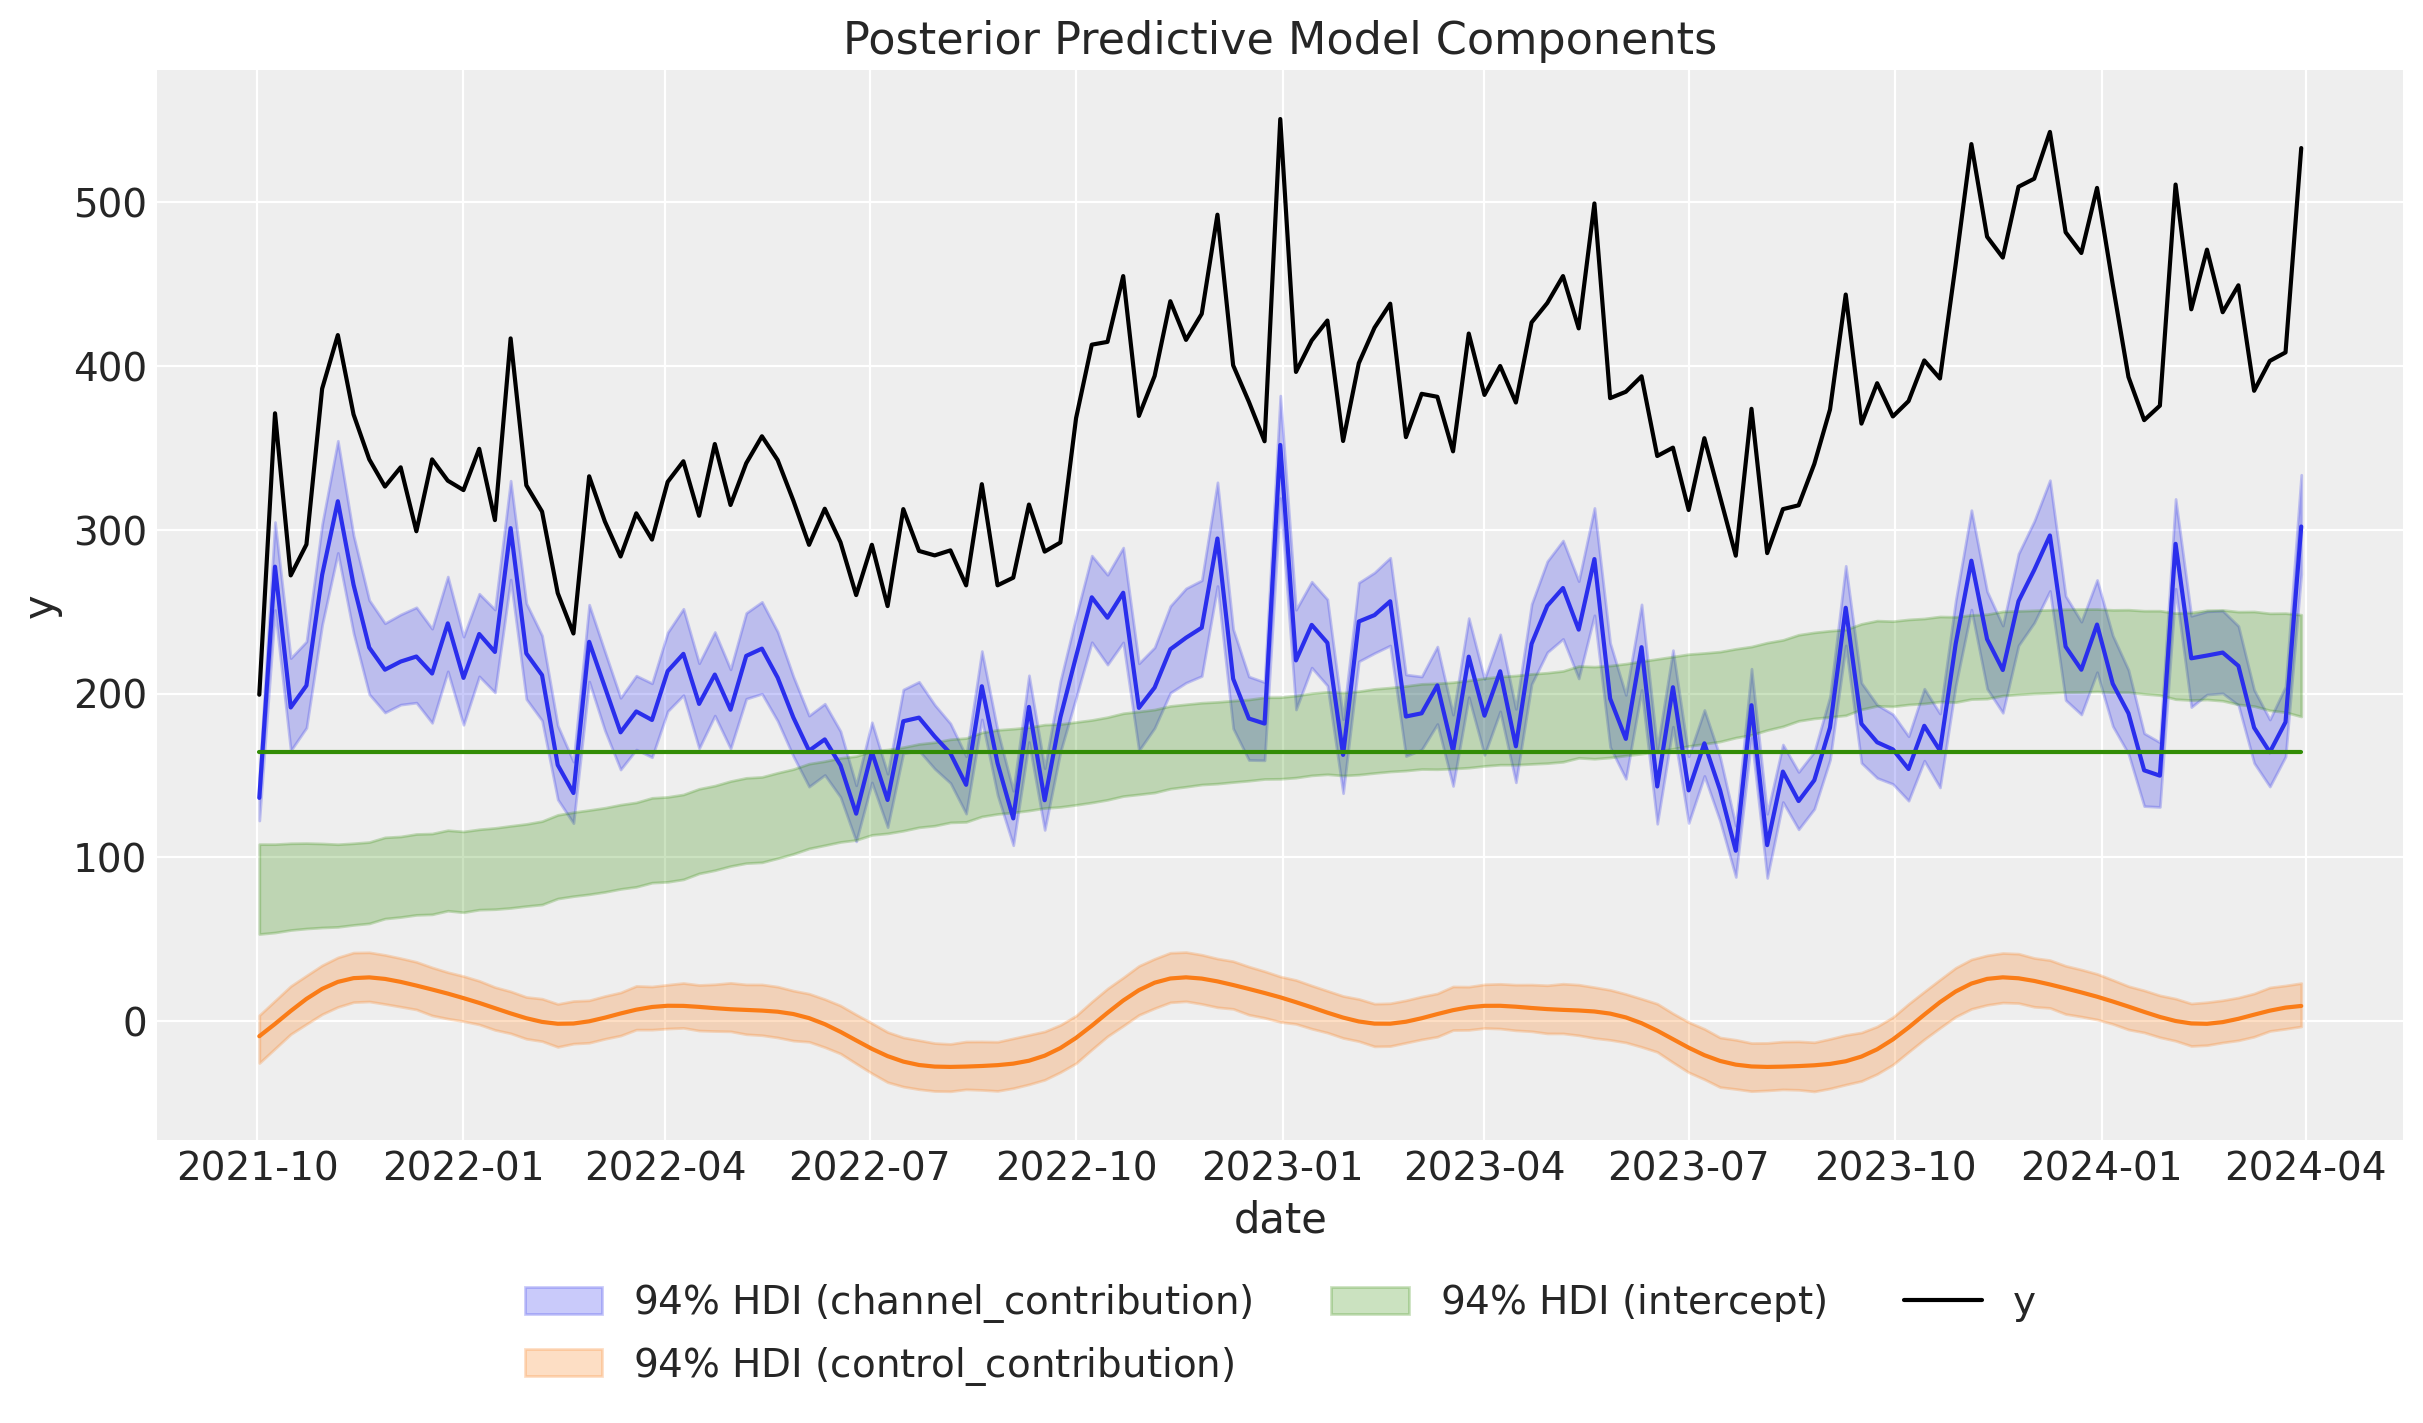

In [7]:
mmm.plot_components_contributions(original_scale=True);

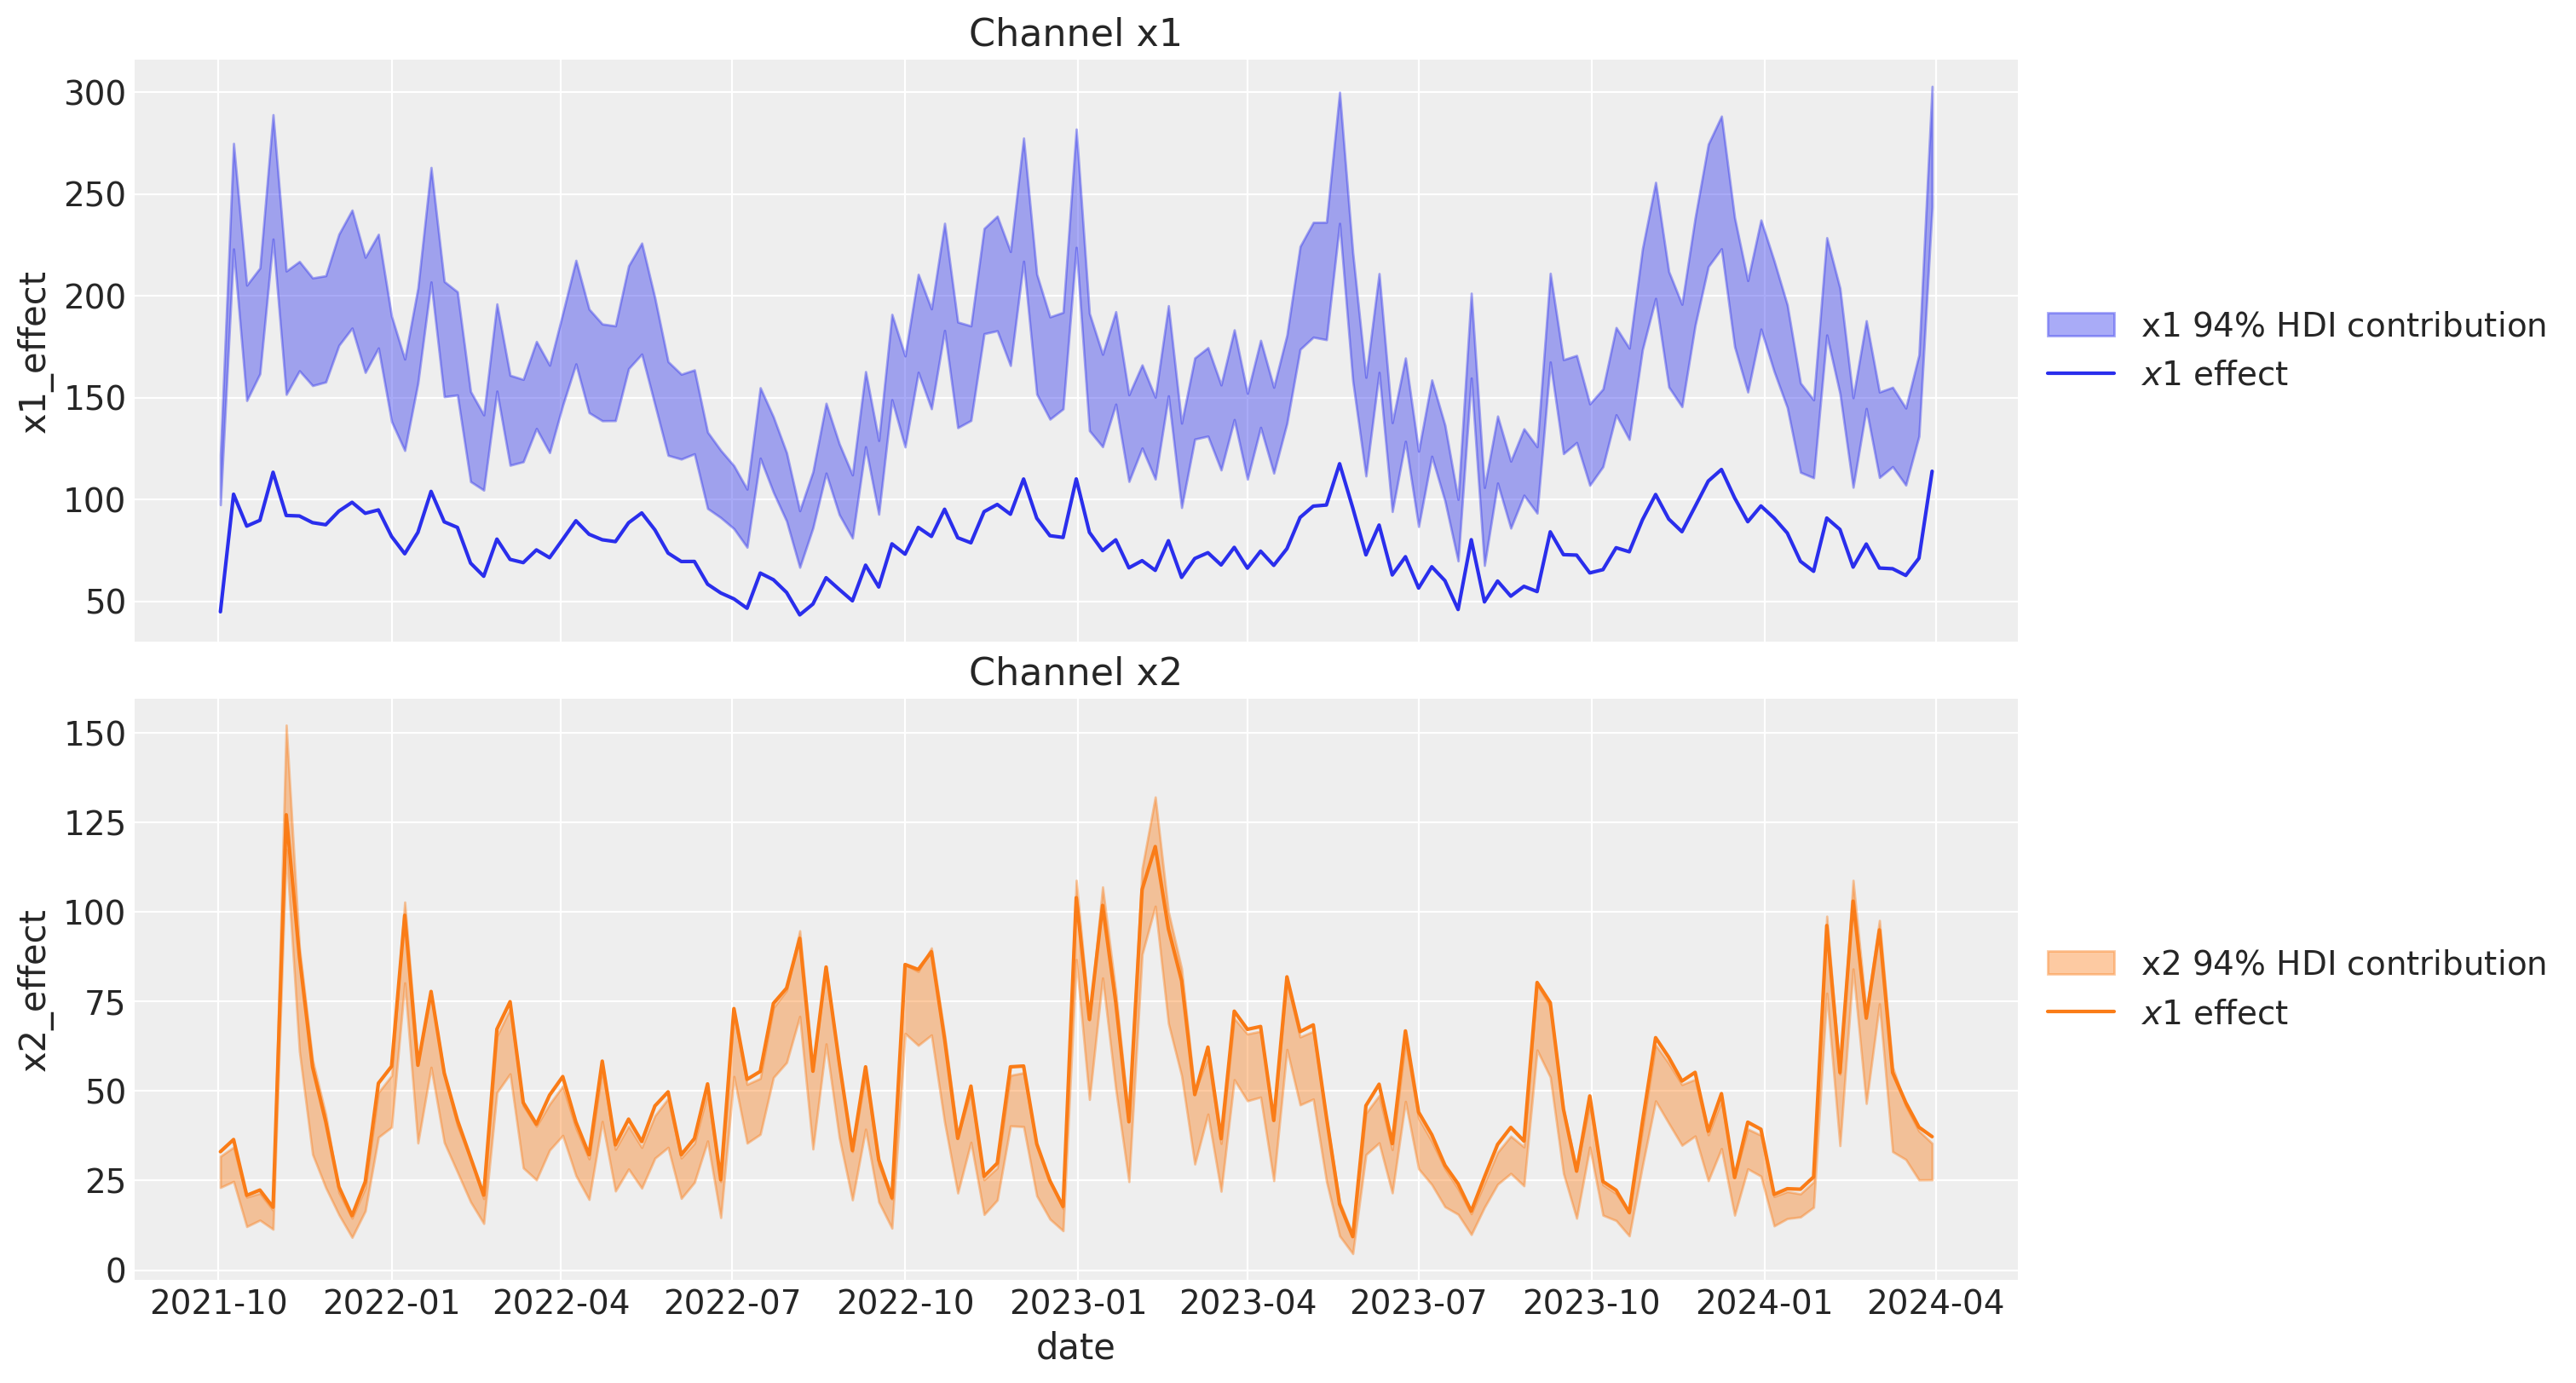

In [8]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

amplitude = 100

for i, x in enumerate(["x1", "x2"]):
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=model_df["date"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x="date",
        y=f"{x}_effect",
        data=raw_df.assign(**{f"{x}_effect": lambda df: amplitude * df[f"{x}_effect"]}),  # noqa B023
        color=f"C{i}",
        label=r"$x1$ effect",
        ax=ax[i],
    )

    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")